# Generative Adversarial Network

# Loading MNIST Data

First, we must add out imports. We will mainly be working with Tensorflow, so we have to import that of course. The next line imports the MNIST data set we will be working with. Numpy is always useful when working with matrices, and in this case, to supply us with a random number generator function. Matplotlib gives us the ability to easily visualize our data as graphs.

In [1]:
# canonical import statements
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
# images (for the discriminator)
X = tf.placeholder(tf.float32, shape=[None, 784])
# noise vector (for the generator)
Z = tf.placeholder(tf.float32, shape=[None, 100])

In [3]:
def xavier(shape):
    return tf.truncated_normal(shape = shape, stddev = 1.0/tf.sqrt(shape[0]/2.0)) #"xavier" initialization of weights

class discriminator_network:
    """MNIST IMAGE(s): x * 784 -> 128 hidden units -> 1 output neuron (probability of being real)"""
    def __init__(self):
        self.d_w1 = tf.Variable(xavier([784,128]))
        self.d_b1 = tf.Variable(tf.zeros(shape=[128]))
        self.d_w2 = tf.Variable(xavier([128,1]))
        self.d_b2 = tf.Variable(tf.zeros(shape=[1]))
    
    def discriminator(self, x):
        """Calculate D(x)"""
        d_hfc_1 = tf.nn.relu(tf.matmul(x, self.d_w1) + self.d_b1)
        d_logit = tf.matmul(d_hfc_1, self.d_w2) + self.d_b2
        d_prob = tf.nn.sigmoid(d_logit)
        return d_prob, d_logit
    
    def get_trainable_vars(self):
        return [self.d_w1, self.d_b1, self.d_w2, self.d_b2]

class generator_network:
    """Random noise vector (100 dim assumed) -> expand to 128 units -> output 784 units (MNIST dim)"""
    def __init__(self):
        self.g_w1 = tf.Variable(xavier([100, 128])) # 100d noise vector assumed. Output 128 hidden units in first layer
        self.g_b1 = tf.Variable(tf.zeros(shape=[128]))
        self.g_w2 = tf.Variable(xavier([128, 784])) # 784 outputs
        self.g_b2 = tf.Variable(tf.zeros(shape=[784]))
    
    def generator(self, z):
        """Calculate and sample G(z)"""
        g_hfc_1 = tf.nn.relu(tf.matmul(z, self.g_w1) + self.g_b1) # 100 * 128 here
        return tf.nn.sigmoid(tf.matmul(g_hfc_1, self.g_w2) + self.g_b2)
    
    def get_trainable_vars(self):
        return [self.g_w1, self.g_b1, self.g_w2, self.g_b2]

In [4]:
# next, we need a function to actually generate a 100d noise vector to feed into our generator
def rand_noise_vector(num_vectors, size):
    return np.random.uniform(-1.0, 1.0, size = [num_vectors, size]) # we might want a bunch of these to generate many imgs

In [5]:
# a function to plot the genned images
def plot(samples, cur_epoch = None):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        # if epoch is not specified we just overwrite the existing image
        plt.savefig("gan{}".format("" if cur_epoch is None else cur_epoch))
        plt.show()

    return fig

In [6]:
# create networks
gen_net, discriminator_net = generator_network(), discriminator_network()
# compute G(z) where z is the random noise vector 
g_sample = gen_net.generator(z=Z)
# compute d(real) = p(image being real)
_, d_logit_real = discriminator_net.discriminator(X)
# compute d(fake) = p(image being real)
_, d_logit_fake = discriminator_net.discriminator(g_sample)

# optimize wrspt to the real logits, so all tha labels are one since we knew they came from real samples
d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels = tf.ones_like(d_logit_real)))
# optimize wrspt to the fake logits, so all the labels are zero since we knew that they came from fake (generated) samples
d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake, labels = tf.zeros_like(d_logit_fake)))
# total loss is just the sum
d_loss = d_real_loss + d_fake_loss

# train the generator w/fake logits
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake, labels = tf.ones_like(d_logit_fake)))

# make sure to only train w/relevant vars
adam = tf.train.AdamOptimizer()
d_step = adam.minimize(d_loss, var_list = discriminator_net.get_trainable_vars())
g_step = adam.minimize(g_loss, var_list = gen_net.get_trainable_vars())

In [7]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


Epoch: 0
Discriminator loss: 1.5899192094802856
Generator loss: 1.7584240436553955


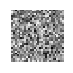

Epoch: 1000
Discriminator loss: 0.20753809809684753
Generator loss: 2.9252827167510986


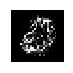

Epoch: 2000
Discriminator loss: 0.6086020469665527
Generator loss: 2.9613285064697266


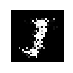

Epoch: 3000
Discriminator loss: 0.40979689359664917
Generator loss: 2.8547840118408203


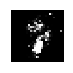

Epoch: 4000
Discriminator loss: 0.9612362384796143
Generator loss: 1.8921175003051758


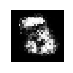

Epoch: 5000
Discriminator loss: 1.47182297706604
Generator loss: 1.4358400106430054


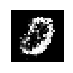

Epoch: 6000
Discriminator loss: 1.5716609954833984
Generator loss: 1.0967895984649658


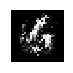

Epoch: 7000
Discriminator loss: 1.3344566822052002
Generator loss: 0.8230522871017456


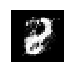

Epoch: 8000
Discriminator loss: 1.3698757886886597
Generator loss: 0.7589877843856812


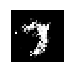

Epoch: 9000
Discriminator loss: 1.2351276874542236
Generator loss: 1.0460197925567627


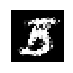

Epoch: 10000
Discriminator loss: 1.3666644096374512
Generator loss: 1.0033093690872192


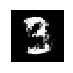

Epoch: 11000
Discriminator loss: 1.3400179147720337
Generator loss: 0.7933043241500854


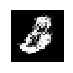

Epoch: 12000
Discriminator loss: 1.4953134059906006
Generator loss: 0.7855602502822876


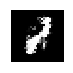

Epoch: 13000
Discriminator loss: 1.1723977327346802
Generator loss: 0.8398014307022095


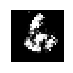

Epoch: 14000
Discriminator loss: 1.167541265487671
Generator loss: 0.8491291999816895


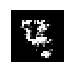

Epoch: 15000
Discriminator loss: 1.2570925951004028
Generator loss: 0.8517584800720215


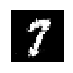

Epoch: 16000
Discriminator loss: 1.2862470149993896
Generator loss: 0.8099907636642456


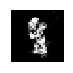

Epoch: 17000
Discriminator loss: 1.3218042850494385
Generator loss: 0.9594565033912659


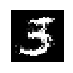

Epoch: 18000
Discriminator loss: 1.2163715362548828
Generator loss: 0.8681243658065796


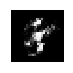

Epoch: 19000
Discriminator loss: 1.2801783084869385
Generator loss: 0.8854254484176636


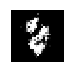

Epoch: 20000
Discriminator loss: 1.26344895362854
Generator loss: 0.9114929437637329


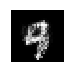

Epoch: 21000
Discriminator loss: 1.2152506113052368
Generator loss: 0.9289005994796753


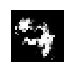

Epoch: 22000
Discriminator loss: 1.1507779359817505
Generator loss: 0.9612971544265747


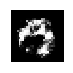

Epoch: 23000
Discriminator loss: 1.1063086986541748
Generator loss: 0.9252835512161255


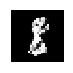

Epoch: 24000
Discriminator loss: 1.190185546875
Generator loss: 1.0184991359710693


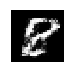

Epoch: 25000
Discriminator loss: 1.126528263092041
Generator loss: 1.071776032447815


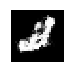

Epoch: 26000
Discriminator loss: 1.1732832193374634
Generator loss: 1.0408560037612915


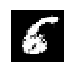

Epoch: 27000
Discriminator loss: 1.196717619895935
Generator loss: 1.094329595565796


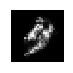

Epoch: 28000
Discriminator loss: 1.0020952224731445
Generator loss: 1.0604770183563232


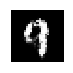

Epoch: 29000
Discriminator loss: 1.143475890159607
Generator loss: 1.065518856048584


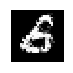

Epoch: 30000
Discriminator loss: 1.0396013259887695
Generator loss: 1.0160419940948486


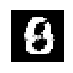

Epoch: 31000
Discriminator loss: 1.0122846364974976
Generator loss: 1.092775583267212


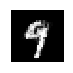

Epoch: 32000
Discriminator loss: 1.058079719543457
Generator loss: 1.2098852396011353


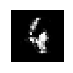

Epoch: 33000
Discriminator loss: 1.0795538425445557
Generator loss: 1.2115955352783203


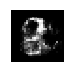

Epoch: 34000
Discriminator loss: 0.9828611612319946
Generator loss: 1.2405729293823242


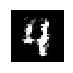

Epoch: 35000
Discriminator loss: 1.1258289813995361
Generator loss: 1.2484928369522095


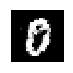

Epoch: 36000
Discriminator loss: 0.8808197975158691
Generator loss: 1.4301857948303223


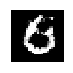

Epoch: 37000
Discriminator loss: 0.9689821004867554
Generator loss: 1.2837047576904297


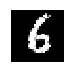

Epoch: 38000
Discriminator loss: 0.9446204900741577
Generator loss: 1.3717269897460938


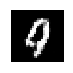

Epoch: 39000
Discriminator loss: 1.0192066431045532
Generator loss: 1.3614323139190674


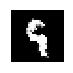

Epoch: 40000
Discriminator loss: 1.0396909713745117
Generator loss: 1.4426250457763672


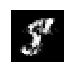

Epoch: 41000
Discriminator loss: 0.8448746204376221
Generator loss: 1.3390696048736572


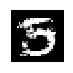

Epoch: 42000
Discriminator loss: 1.007749319076538
Generator loss: 1.2676284313201904


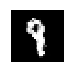

Epoch: 43000
Discriminator loss: 0.9332622289657593
Generator loss: 1.4716684818267822


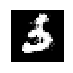

Epoch: 44000
Discriminator loss: 0.9782637357711792
Generator loss: 1.4198176860809326


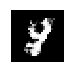

Epoch: 45000
Discriminator loss: 0.9709283113479614
Generator loss: 1.3724205493927002


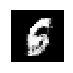

Epoch: 46000
Discriminator loss: 0.8999639749526978
Generator loss: 1.6235300302505493


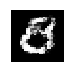

Epoch: 47000
Discriminator loss: 0.8698982000350952
Generator loss: 1.3764379024505615


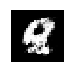

Epoch: 48000
Discriminator loss: 0.9583990573883057
Generator loss: 1.5038225650787354


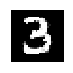

Epoch: 49000
Discriminator loss: 0.8385083675384521
Generator loss: 1.5915305614471436


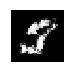

Epoch: 50000
Discriminator loss: 0.9019622802734375
Generator loss: 1.5459048748016357


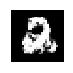

Epoch: 51000
Discriminator loss: 0.8983498811721802
Generator loss: 1.6210036277770996


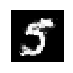

Epoch: 52000
Discriminator loss: 0.9611755609512329
Generator loss: 1.4901701211929321


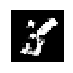

Epoch: 53000
Discriminator loss: 0.9630222320556641
Generator loss: 1.536405086517334


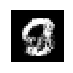

Epoch: 54000
Discriminator loss: 0.9882720708847046
Generator loss: 1.8198564052581787


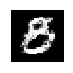

Epoch: 55000
Discriminator loss: 0.92844557762146
Generator loss: 1.5117374658584595


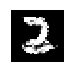

Epoch: 56000
Discriminator loss: 0.7716194987297058
Generator loss: 1.8830829858779907


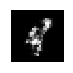

Epoch: 57000
Discriminator loss: 0.7942794561386108
Generator loss: 1.8674860000610352


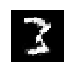

Epoch: 58000
Discriminator loss: 0.8824076652526855
Generator loss: 1.6865860223770142


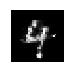

Epoch: 59000
Discriminator loss: 0.7869680523872375
Generator loss: 1.5940450429916382


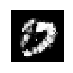

Epoch: 60000
Discriminator loss: 0.8717421293258667
Generator loss: 1.7797977924346924


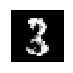

Epoch: 61000
Discriminator loss: 0.8484574556350708
Generator loss: 1.6720715761184692


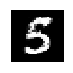

Epoch: 62000
Discriminator loss: 0.8965802788734436
Generator loss: 1.9516277313232422


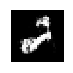

Epoch: 63000
Discriminator loss: 0.8478789329528809
Generator loss: 1.774067997932434


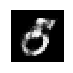

Epoch: 64000
Discriminator loss: 0.824718713760376
Generator loss: 1.8843469619750977


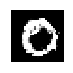

Epoch: 65000
Discriminator loss: 0.7154836058616638
Generator loss: 1.917673945426941


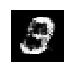

Epoch: 66000
Discriminator loss: 0.7479954361915588
Generator loss: 1.420649528503418


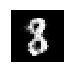

Epoch: 67000
Discriminator loss: 0.7374100685119629
Generator loss: 1.6726102828979492


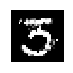

Epoch: 68000
Discriminator loss: 0.7532471418380737
Generator loss: 1.7392146587371826


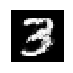

Epoch: 69000
Discriminator loss: 0.7143362164497375
Generator loss: 1.7840521335601807


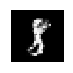

Epoch: 70000
Discriminator loss: 0.6926231384277344
Generator loss: 1.618638515472412


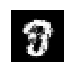

Epoch: 71000
Discriminator loss: 0.8356431722640991
Generator loss: 1.7292369604110718


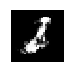

Epoch: 72000
Discriminator loss: 0.8637713193893433
Generator loss: 1.7350486516952515


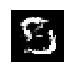

Epoch: 73000
Discriminator loss: 0.8019428253173828
Generator loss: 1.583104133605957


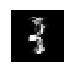

Epoch: 74000
Discriminator loss: 0.8545218706130981
Generator loss: 1.715652346611023


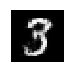

Epoch: 75000
Discriminator loss: 0.8053542375564575
Generator loss: 1.7703956365585327


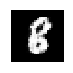

Epoch: 76000
Discriminator loss: 0.8155567049980164
Generator loss: 1.7814897298812866


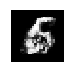

Epoch: 77000
Discriminator loss: 0.7954710721969604
Generator loss: 1.8656724691390991


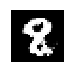

Epoch: 78000
Discriminator loss: 0.6635657548904419
Generator loss: 1.765702486038208


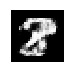

Epoch: 79000
Discriminator loss: 0.8142183423042297
Generator loss: 1.6275497674942017


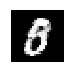

Epoch: 80000
Discriminator loss: 0.6114515662193298
Generator loss: 1.7888261079788208


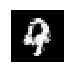

Epoch: 81000
Discriminator loss: 0.7632625102996826
Generator loss: 1.8664088249206543


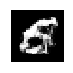

Epoch: 82000
Discriminator loss: 0.6982200145721436
Generator loss: 1.9997222423553467


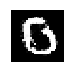

Epoch: 83000
Discriminator loss: 0.8616249561309814
Generator loss: 2.161841869354248


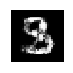

Epoch: 84000
Discriminator loss: 0.8614253997802734
Generator loss: 1.8903900384902954


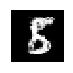

Epoch: 85000
Discriminator loss: 0.7347594499588013
Generator loss: 1.6274744272232056


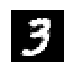

Epoch: 86000
Discriminator loss: 0.9512251615524292
Generator loss: 1.7747447490692139


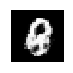

Epoch: 87000
Discriminator loss: 0.6514798402786255
Generator loss: 1.8384851217269897


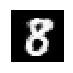

Epoch: 88000
Discriminator loss: 0.6939690113067627
Generator loss: 1.9729443788528442


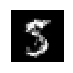

Epoch: 89000
Discriminator loss: 0.719268798828125
Generator loss: 1.844036340713501


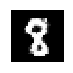

Epoch: 90000
Discriminator loss: 0.7356226444244385
Generator loss: 1.941338062286377


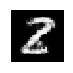

Epoch: 91000
Discriminator loss: 0.749530553817749
Generator loss: 2.0260047912597656


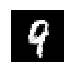

Epoch: 92000
Discriminator loss: 0.6045534014701843
Generator loss: 2.126569986343384


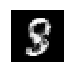

Epoch: 93000
Discriminator loss: 0.6463720202445984
Generator loss: 2.0417468547821045


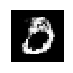

Epoch: 94000
Discriminator loss: 0.7938376069068909
Generator loss: 1.8935749530792236


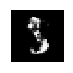

Epoch: 95000
Discriminator loss: 0.8341561555862427
Generator loss: 1.7587685585021973


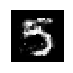

Epoch: 96000
Discriminator loss: 0.5870354175567627
Generator loss: 2.0812087059020996


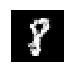

Epoch: 97000
Discriminator loss: 0.7591317296028137
Generator loss: 1.7490527629852295


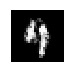

Epoch: 98000
Discriminator loss: 0.5895116329193115
Generator loss: 1.8049880266189575


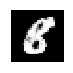

Epoch: 99000
Discriminator loss: 0.67311692237854
Generator loss: 1.9433279037475586


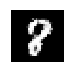

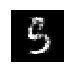

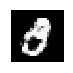

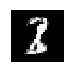

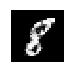

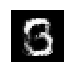

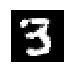

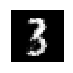

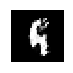

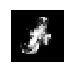

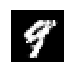

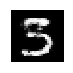

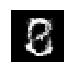

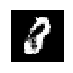

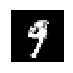

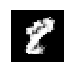

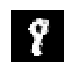

In [8]:

%matplotlib inline
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i = 0
    for epoch in range(100000): # increase this for more accuracy, but it will be more likely to collapse
        X_mb, _ = mnist.train.next_batch(128)
        _, cur_loss_d = sess.run([d_step, d_loss], feed_dict = {X: X_mb, Z: rand_noise_vector(128, 100)})
        _, cur_loss_g = sess.run([g_step, g_loss], feed_dict = {Z: rand_noise_vector(128, 100)})
        _, cur_loss_g = sess.run([g_step, g_loss], feed_dict = {Z: rand_noise_vector(128, 100)})
        if epoch % 1000 == 0:
            print("Epoch: {}".format(epoch))
            print("Discriminator loss: {}".format(cur_loss_d))
            print("Generator loss: {}".format(cur_loss_g))
            samples = sess.run(g_sample, feed_dict={Z: rand_noise_vector(1, 100)})
            plot(samples, epoch)
    samples = sess.run(g_sample, feed_dict={Z: rand_noise_vector(16, 100)})
    plot(samples) # 16 of em